In [1]:
# change directory
import os
rootdir = os.path.dirname(os.getcwd())
os.chdir(rootdir)

# make imports
from utils import rendering as vw

In [2]:
benchmarkid = 'Dialysis2021'
dbmsid = 'Sqlite'

In [3]:
ganttview = vw.GanttView(benchmarkid, dbmsid)
ganttview

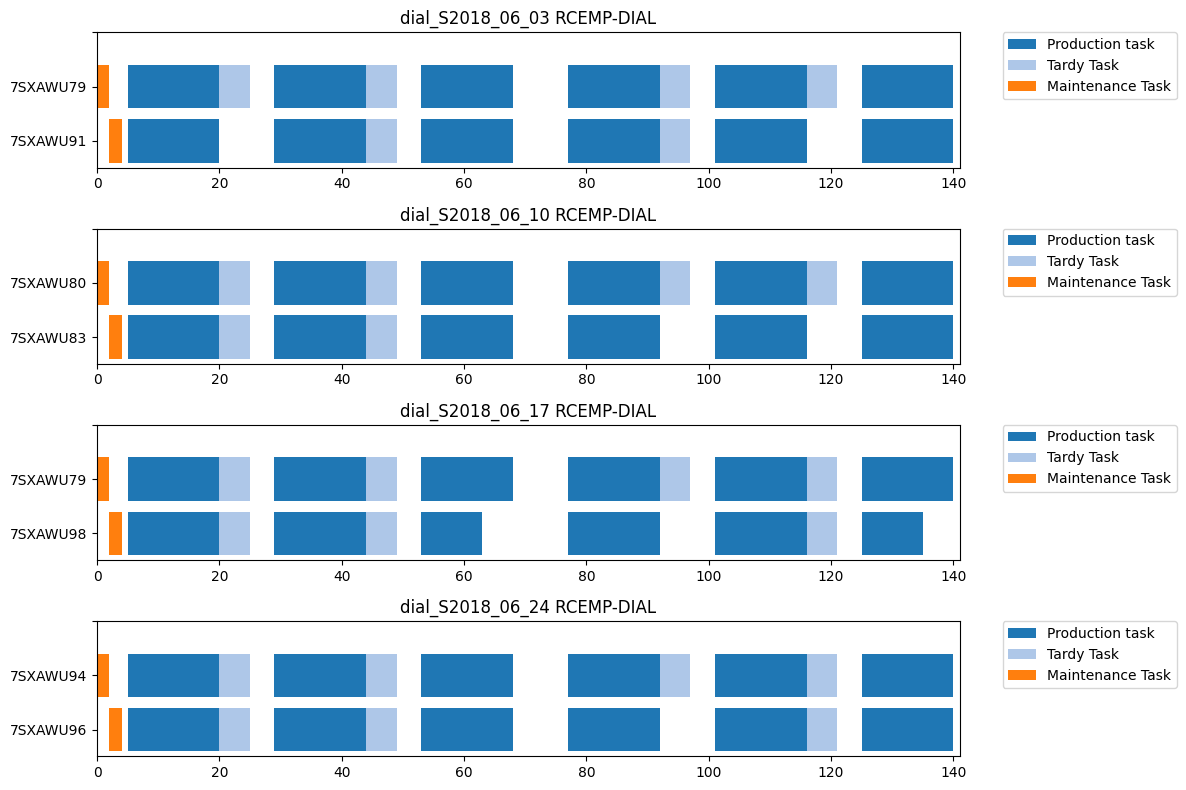

In [4]:
f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
ganttview.plot('dial_S2018%', '%CEMP%', title_format=f)

In [5]:
# f = lambda exp: f"{exp['problem_name'][:-2].replace('_', '-')} ({exp['model_name'][:-5]})"
# f = lambda exp: '(a)' if exp['model_name'][:-5] == 'SCEMP' else '(b)'
# ganttview.plot('k1_20_3', '%CEMP%', title_format=f, time_window=(0, 1200), saveas='gantt_comparison.png')

In [6]:
# prod_var_names = ['Cmax', 'R', 'nR']
# statsview = vw.StatsView(benchmarkid, dbmsid)
# statsview.compare('RCEMPModel', 'SCEMPModel', prod_var_names, 
#                   instance_pattern='(\S+)_\d+', by_method=True,
#                   save_as='prod_performances.csv')

In [7]:
# maint_var_names = ['nTM', 'Abar']
# statsview.compare('RCEMPModel', 'SCEMPModel', maint_var_names, 
#                   instance_pattern='(\S+)_\d+', by_method=True,
#                   save_as='maint_performances.csv')

In [8]:
# exec_var_names = ['nC', 'Es']
# statsview.compare('RCEMPModel', 'SCEMPModel', exec_var_names, 
#                   instance_pattern='(\S+)_\d+', by_method=True,
#                   save_as='exec_performances.csv')

In [9]:
# var_names = prod_var_names + maint_var_names + exec_var_names
# statsview.test(var_names, problem_filter='%', save_as='test_performances.csv')